# Loading the Data

In [1]:
import json
import re
from os.path import join
import os

import pandas as pd
import numpy as np
from tqdm import tqdm
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import optuna
import shap
import cfbd
from sklearn.metrics import log_loss, accuracy_score, classification_report, confusion_matrix, roc_auc_score
import numpy as np

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

with open('../config.json') as f:
    configuration = cfbd.Configuration(
        access_token = json.load(f)['CFBD_API_KEY']
    )

In [2]:
YEARS = range(2013, 2025)
DATA_DIR = '../data'

In [3]:
def convert_to_snake_case(cols):
    cols_new = []
    for c in cols:
        s1 = re.sub('(.)([A-Z][a-z]+)', r'\1_\2', c)
        cols_new.append(re.sub('([a-z0-9])([A-Z])', r'\1_\2', s1).lower().replace('t_ds', 'tds'))
    return cols_new

In [4]:
# Load weather data
all_dfs = []

weather_dir = join(DATA_DIR, 'weather')
if not os.path.exists(weather_dir):
    os.makedirs(weather_dir)

for year in YEARS:
    file_path = join(weather_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} weather data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_weather(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

weather = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
weather.head()

Reading ../data/weather/2013.parquet from cached data
Reading ../data/weather/2014.parquet from cached data
Reading ../data/weather/2015.parquet from cached data
Reading ../data/weather/2016.parquet from cached data
Reading ../data/weather/2017.parquet from cached data
Reading ../data/weather/2018.parquet from cached data
Reading ../data/weather/2019.parquet from cached data
Reading ../data/weather/2020.parquet from cached data
Reading ../data/weather/2021.parquet from cached data
Reading ../data/weather/2022.parquet from cached data
Reading ../data/weather/2023.parquet from cached data
Reading ../data/weather/2024.parquet from cached data


,id,season,week,season_type,start_time,game_indoors,home_team,home_conference,away_team,away_conference,venue_id,venue,temperature,dew_point,humidity,precipitation,snowfall,wind_direction,wind_speed,pressure,weather_condition_code,weather_condition
0,333272229,2013,13,regular,2013-11-23 23:00:00+00:00,False,Florida International,Conference USA,Marshall,Conference USA,218,FIU Stadium,78.1,70.0,76.0,0.0,0,70.0,5.8,1015.9,NaN,None
1,333062229,2013,10,regular,2013-11-02 22:00:00+00:00,False,Florida International,Conference USA,East Carolina,Conference USA,218,FIU Stadium,84.9,65.8,53.0,0.0,0,260.0,7.0,1010.5,NaN,None
2,332992229,2013,9,regular,2013-10-26 22:00:00+00:00,False,Florida International,Conference USA,Louisiana Tech,Conference USA,218,FIU Stadium,79.0,61.0,54.0,0.0,0,60.0,11.4,1018.2,NaN,None
3,332852229,2013,7,regular,2013-10-12 23:30:00+00:00,False,Florida International,Conference USA,UAB,Conference USA,218,FIU Stadium,81.0,66.2,61.0,0.0,0,50.0,8.1,1015.9,NaN,None
4,332572229,2013,3,regular,2013-09-14 22:00:00+00:00,False,Florida International,Conference USA,Bethune-Cookman,MEAC,218,FIU Stadium,88.0,73.8,63.0,0.0,0,110.0,11.4,1013.0,NaN,None


In [5]:
# Load games data
all_dfs = []
id_cols = ['id', 'season', 'week', 'season_type', 'completed', 'neutral_site', 'venue_id']
home_cols = ['home_id', 'home_team', 'home_conference', 'home_division', 'home_points', 'home_pregame_elo']
away_cols = ['away_id', 'away_team', 'away_conference', 'away_division', 'away_points', 'away_pregame_elo']

games_dir = join(DATA_DIR, 'games')
if not os.path.exists(games_dir):
    os.makedirs(games_dir)


for year in range(2012, 2025): # Adjusted to include 2012 for rolling window
    file_path = join(games_dir, f'{year}.parquet')
    if os.path.exists(file_path):
        print(f'Reading {file_path} from cached data')
        tmp = pd.read_parquet(file_path)
    else:
        print(f'Fetching {year} games data from CFBD API')
        with cfbd.ApiClient(configuration) as api_client:
            api_instance = cfbd.GamesApi(api_client)
            data = api_instance.get_games(year=year)
        tmp = pd.DataFrame([val.to_dict() for val in data])
        tmp.columns = convert_to_snake_case(tmp.columns)
        tmp = tmp[id_cols + [
                            'home_id','home_team','home_conference','home_classification','home_points','home_pregame_elo',
                            'away_id','away_team','away_conference','away_classification','away_points','away_pregame_elo']]
        tmp['season_type'] = tmp['season_type'].apply(lambda x: x.value)
        tmp = tmp.assign(
            home_division=tmp['home_classification'].apply(lambda x: x.value if x is not None else None),
            away_division=tmp['away_classification'].apply(lambda x: x.value if x is not None else None)
        ).drop(columns=['home_classification','away_classification'])
        tmp = tmp[id_cols + home_cols + away_cols]
        tmp.to_parquet(file_path)
    all_dfs.append(tmp)
del tmp

games = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
games.head()

Reading ../data/games/2012.parquet from cached data
Reading ../data/games/2013.parquet from cached data
Reading ../data/games/2014.parquet from cached data
Reading ../data/games/2015.parquet from cached data
Reading ../data/games/2016.parquet from cached data
Reading ../data/games/2017.parquet from cached data
Reading ../data/games/2018.parquet from cached data
Reading ../data/games/2019.parquet from cached data
Reading ../data/games/2020.parquet from cached data
Reading ../data/games/2021.parquet from cached data
Reading ../data/games/2022.parquet from cached data
Reading ../data/games/2023.parquet from cached data
Reading ../data/games/2024.parquet from cached data


,id,season,week,season_type,completed,neutral_site,venue_id,home_id,home_team,home_conference,home_division,home_points,home_pregame_elo,away_id,away_team,away_conference,away_division,away_points,away_pregame_elo,start_date
0,322432710,2012,1,regular,True,False,3746.0,2710,Western Illinois,MVFC,fcs,23.0,NaN,2086,Butler,Pioneer,fcs,15.0,NaN,NaT
1,322432117,2012,1,regular,True,False,3786.0,2117,Central Michigan,Mid-American,fbs,38.0,NaN,2546,Southeast Missouri State,OVC,fcs,27.0,NaN,NaT
2,322432050,2012,1,regular,True,False,3919.0,2050,Ball State,Mid-American,fbs,37.0,1299.0,2199,Eastern Michigan,Mid-American,fbs,26.0,1231.0,NaT
3,322432006,2012,1,regular,True,False,3768.0,2006,Akron,Mid-American,fbs,14.0,997.0,2116,UCF,Conference USA,fbs,56.0,1559.0,NaT
4,322430238,2012,1,regular,True,False,3973.0,238,Vanderbilt,SEC,fbs,13.0,1573.0,2579,South Carolina,SEC,fbs,17.0,1743.0,NaT


In [6]:
# Load plays data
all_dfs = []
cols = ['id', 'drive_id', 'game_id', 'drive_number', 'play_number', 'offense',
       'offense_conference', 'offense_score', 'defense', 'home', 'away',
       'defense_conference', 'defense_score', 'period', 'offense_timeouts',
       'defense_timeouts', 'yardline', 'yards_to_goal', 'down', 'distance',
       'yards_gained', 'scoring', 'play_type', 'play_text', 'ppa',
       'clock_minutes', 'clock_seconds']

plays_dir = join(DATA_DIR, 'plays')
if not os.path.exists(plays_dir):
    os.makedirs(plays_dir)

for year in range(2012, 2025):
    season_file_path = join(plays_dir, f'{year}.parquet')
    
    if os.path.exists(season_file_path):
        print(f'Reading {season_file_path} from cached data')
        season_plays = pd.read_parquet(season_file_path)
    else:
        print(f'Fetching all weeks plays data for {year} from CFBD API')
        weeks = games.query('season == @year').week.unique().tolist()

        season_dfs = []
        for week in weeks:
            print(f'Fetching {year} plays data for week {week} from CFBD API')
            with cfbd.ApiClient(configuration) as api_client:
                api_instance = cfbd.PlaysApi(api_client)
                data = api_instance.get_plays(year=year, week=week)
            tmp = pd.DataFrame([val.to_dict() for val in data])
            if tmp.empty:
                print(f'No plays data for {year} week {week}')
                continue
            tmp.columns = convert_to_snake_case(tmp.columns)

            tmp['clock_minutes'] = tmp['clock'].apply(lambda x: x['minutes'])
            tmp['clock_seconds'] = tmp['clock'].apply(lambda x: x['seconds'])
            tmp.drop(columns=['clock'], inplace=True)

            tmp = tmp[cols]
            season_dfs.append(tmp)
        
        season_plays = pd.concat(season_dfs, ignore_index=True).reset_index(drop=True)
        
        season_plays.to_parquet(season_file_path)
        print(f'Saved plays data for {year} to {season_file_path}')
        del season_dfs, tmp

    all_dfs.append(season_plays)

    del season_plays
    
plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)
plays.columns = plays.columns.str.replace('t_ds', 'tds', regex=False)
plays.head()

Reading ../data/plays/2012.parquet from cached data
Reading ../data/plays/2013.parquet from cached data
Reading ../data/plays/2014.parquet from cached data
Reading ../data/plays/2015.parquet from cached data
Reading ../data/plays/2016.parquet from cached data
Reading ../data/plays/2017.parquet from cached data
Reading ../data/plays/2018.parquet from cached data
Reading ../data/plays/2019.parquet from cached data
Reading ../data/plays/2020.parquet from cached data
Reading ../data/plays/2021.parquet from cached data
Reading ../data/plays/2022.parquet from cached data
Reading ../data/plays/2023.parquet from cached data
Reading ../data/plays/2024.parquet from cached data


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_24317/2051513579.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  plays = pd.concat(all_dfs, ignore_index=True).reset_index(drop=True)


,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds
0,322450221037,32245022104,322450221,4,1,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,1,NaN,NaN,92,92,1,10,2,False,Rush,"Jamaine Cook rush for 2 yards to the YngSt 10,...",-0.207100,2,47
1,322450221048,32245022104,322450221,4,11,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,2,NaN,NaN,36,36,2,4,0,False,Rush,"Kurt Hess rush for no gain to the Pitt 36, tac...",-0.903926,15,0
2,322450221044,32245022104,322450221,4,7,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,2,NaN,NaN,59,59,1,10,0,False,Pass Incompletion,"Kurt Hess pass incomplete to Christian Bryan, ...",-1.138786,15,0
3,322450221045,32245022104,322450221,4,8,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,2,NaN,NaN,59,59,2,10,5,False,Pass Completion,Kurt Hess pass complete to Marcel Caver for 5 ...,0.068045,15,0
4,322450221041,32245022104,322450221,4,5,Youngstown State,MVFC,7,Pittsburgh,Pittsburgh,Youngstown State,Big East,7,1,NaN,NaN,73,73,2,8,0,False,Pass Incompletion,"Kurt Hess pass incomplete to Christian Bryan, ...",-0.478808,2,47


In [7]:
elos = []
for year in YEARS:
    elos.append(pd.read_parquet(join(DATA_DIR, 'elo', f'{year}.parquet')))
elo = pd.concat(elos, ignore_index=True).reset_index(drop=True)
elo = elo.drop_duplicates(subset=['season', 'week', 'team_id'], keep='first')
elo.head()

,season,week,team_id,team,division,elo
0,2013,1,2,Auburn,fbs,2266.299104
2,2013,2,2,Auburn,fbs,2256.315253
3,2013,3,2,Auburn,fbs,2304.848707
4,2013,4,2,Auburn,fbs,2346.432593
5,2013,6,2,Auburn,fbs,2340.107671


In [8]:
# Load venue data
venue_dir = join(DATA_DIR, 'venues')
if not os.path.exists(venue_dir):
    os.makedirs(venue_dir)

file_path = join(venue_dir, f'venues.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    venues = pd.read_parquet(file_path)
else:
    print(f'Fetching {year} venue data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.VenuesApi(api_client)
        data = api_instance.get_venues()
    venues = pd.DataFrame([val.to_dict() for val in data])
    venues.columns = convert_to_snake_case(venues.columns)
    venues.to_parquet(file_path)

venues.head()

Reading ../data/venues/venues.parquet from cached data


,id,name,city,state,zip,country_code,latitude,longitude,capacity,dome,timezone,elevation,construction_year,grass
0,5938,Al Whitehead Field at Greyhound Stadium,Portales,NM,88130,US,34.186192,-103.334397,4000.0,False,None,None,NaN,None
1,218,FIU Stadium,Miami,FL,33199,US,25.752501,-80.377891,20000.0,False,America/New_York,1.718581796,1995.0,False
2,4779,Thomas A. Robinson National Stadium,Nassau,,None,BS,25.055569,-77.358736,15000.0,False,None,3.182889223,1981.0,True
3,5220,Garrison Stadium,Murfreesboro,TN,None,US,36.434053,-77.098431,5000.0,False,None,18.69116974,2007.0,None
4,6043,Bethpage Federal Credit Union Stadium,Brookville,NY,11545,US,40.816284,-73.589546,6000.0,False,America/New_York,236,1966.0,False


In [9]:
fg_ep_dir = join(DATA_DIR, 'fg_expected_points')
if not os.path.exists(fg_ep_dir):
    os.makedirs(fg_ep_dir)
    
file_path = join(fg_ep_dir, 'fg_ep.parquet')
if os.path.exists(file_path):
    print(f'Reading {file_path} from cached data')
    fg_ep = pd.read_parquet(file_path)
else:
    print(f'Fetching field goal expected points data from CFBD API')
    with cfbd.ApiClient(configuration) as api_client:
        api_instance = cfbd.MetricsApi(api_client)
        data = api_instance.get_field_goal_expected_points()
    fg_ep = pd.DataFrame([val.to_dict() for val in data])
    fg_ep.columns = convert_to_snake_case(fg_ep.columns)
    fg_ep.to_parquet(file_path)
fg_ep.head()

Reading ../data/fg_expected_points/fg_ep.parquet from cached data


,yards_to_goal,distance,expected_points
0,0,17,2.85
1,1,18,2.84
2,2,19,2.82
3,3,20,2.81
4,4,21,2.79


In [10]:
fg_points_over_expectation = (
    pd.concat([
        games[['id', 'season', 'week', 'season_type', 'home_team']]
            .rename(columns={'id': 'game_id', 'home_team': 'team'}),
        games[['id', 'season', 'week', 'season_type', 'away_team']]
            .rename(columns={'id': 'game_id', 'away_team': 'team'})
    ], ignore_index=True)
    .merge(
        plays[['game_id','offense',
            'yards_to_goal', 'play_type','play_text']]
            .rename(columns={'offense': 'team'})
            .query('0 <= yards_to_goal <= 48') # Max 65 yard FG
            .query('play_type.str.contains("Field Goal")'),
        on=['game_id', 'team'],
        how='left'
    )
    .merge(
        fg_ep[['yards_to_goal', 'expected_points']],
        left_on='yards_to_goal',
        right_on='yards_to_goal',
        how='left'
    )
    .assign(
        points_over_expectation=lambda x: np.where(
            x.play_type == 'Field Goal Good',
            3 - x.expected_points,
            -x.expected_points 
        )
    )
    .groupby(['game_id', 'team', 'season', 'season_type', 'week'], as_index=False)
    .agg(
        total_poe=('points_over_expectation', 'sum'),
        fg_attempts=('points_over_expectation', 'count'),
        longest_fg=('yards_to_goal', 'max')
    )
    .assign(
        longest_fg=lambda x: x.longest_fg.fillna(0).astype(int)
    )
    .sort_values(
        by=['team', 'season', 'season_type', 'week'], 
        ignore_index=True, 
        ascending=[True, True, False, True]
    )
)


shifted = fg_points_over_expectation.groupby('team')[['fg_attempts', 'total_poe', 'longest_fg']].shift(1)

# Roling for last 12 games
rolling = (
    shifted.groupby(fg_points_over_expectation['team'])
    .rolling(window=12, min_periods=12)
    .agg({
        'fg_attempts': 'sum',
        'total_poe': 'sum',
        'longest_fg': 'max'
    })
    .reset_index(level=0, drop=True)
    .add_prefix('last12_')
)
fg_poe_rolling = pd.concat([fg_points_over_expectation.iloc[:,:5], rolling], axis=1)
fg_poe_rolling['last12_total_poe_gaussian'] = (
    fg_poe_rolling
    .groupby('team')['last12_total_poe']
    .transform(lambda x: x.rolling(window=5, win_type='gaussian', min_periods=1).mean(std=1.0))
)

# Rolling for last 6 games
rolling = (
    shifted.groupby(fg_points_over_expectation['team'])
    .rolling(window=6, min_periods=6)
    .agg({
        'fg_attempts': 'sum',
        'total_poe': 'sum',
        'longest_fg': 'max'
    })
    .reset_index(level=0, drop=True)
    .add_prefix('last6_')
)
fg_poe_rolling_6 = pd.concat([fg_points_over_expectation.iloc[:,:5], rolling], axis=1)
fg_poe_rolling_6['last6_total_poe_gaussian'] = (
    fg_poe_rolling_6
    .groupby('team')['last6_total_poe']
    .transform(lambda x: x.rolling(window=5, win_type='gaussian', min_periods=1).mean(std=1.0))
)

fg_poe_rolling = fg_poe_rolling.merge(
    fg_poe_rolling_6[['game_id', 'team', 'last6_fg_attempts', 'last6_total_poe', 'last6_longest_fg', 'last6_total_poe_gaussian']],
    on=['game_id', 'team'],
    how='left'
)

fg_poe_rolling.head()

,game_id,team,season,season_type,week,last12_fg_attempts,last12_total_poe,last12_longest_fg,last12_total_poe_gaussian,last6_fg_attempts,last6_total_poe,last6_longest_fg,last6_total_poe_gaussian
0,332432000,Abilene Christian,2013,regular,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,332502000,Abilene Christian,2013,regular,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,332572000,Abilene Christian,2013,regular,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,332642287,Abilene Christian,2013,regular,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,332712000,Abilene Christian,2013,regular,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Data Engineering

In [32]:
fg_attempts = (
    plays
    .merge(
        games[['id', 'season']].rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .query('season >= 2013')  # Filter out seasons before 2013
    .drop(columns=['season'])
    .assign(play_text=plays.play_text.fillna('')
            .str.replace(',', '', regex=False)
            .str.replace('.', '', regex=False)
            .str.lower())
    .assign(play_text=lambda x: ' ' + x.play_text + ' ')
    .query(
        'down.isin([1,2,3,4]) and '
        'period.isin([1, 2, 3, 4]) and '
        '(play_type.str.contains("Field Goal") | '
        ' play_text.str.contains(" field goal ") | '
        ' play_text.str.contains(" fg "))'
    )
    .assign(
        fg_outcome=lambda x: np.select(
            [
                x.play_text.str.contains(' blocked ') | x.play_text.str.contains(' block '),
                x.play_text.str.contains(' missed ') | 
                x.play_text.str.contains(' no good ') | (
                    x.play_text.str.contains(' miss ') &
                    ~x.play_text.str.contains(' ole miss ') &
                    ~x.play_text.str.contains(' southern miss ')
                ),
                (
                    x.play_text.str.contains(' good ') | 
                    x.play_text.str.contains(' made ') |
                    (x.play_type == "Field Goal Good")
                ),
                x.play_type.isin([
                    "Field Goal Missed",
                    "Missed Field Goal Return",
                    "Missed Field Goal Return Touchdown"
                ]),
                x.play_type.isin([
                    "Blocked Field Goal",
                    "Blocked Field Goal Touchdown"
                ])
            ],
            [
                'blocked',
                'missed',
                'good',
                'missed',
                'blocked'
            ],
            default='unknown'
        )
    )
    .query('fg_outcome != "unknown"')
    .reset_index(drop=True)
)

fg_attempts.head()

,id,drive_id,game_id,drive_number,play_number,offense,offense_conference,offense_score,defense,home,away,defense_conference,defense_score,period,offense_timeouts,defense_timeouts,yardline,yards_to_goal,down,distance,yards_gained,scoring,play_type,play_text,ppa,clock_minutes,clock_seconds,fg_outcome
0,333610120120,33361012012,333610120,12,11,Maryland,ACC,13,Marshall,Maryland,Marshall,Conference USA,17,2,3.0,2.0,86,14,4,5,33,True,Field Goal Good,brad craddock 33 yard field goal good,-0.621830,1,20,good
1,333610120075,33361012008,333610120,8,10,Maryland,ACC,10,Marshall,Maryland,Marshall,Conference USA,14,2,3.0,3.0,93,7,4,7,25,True,Field Goal Good,brad craddock 25 yard field goal good,-0.790370,11,36,good
2,332430120241,33243012025,332430120,25,10,Maryland,ACC,43,Florida International,Maryland,Florida International,Conference USA,10,4,3.0,3.0,95,5,4,5,23,True,Field Goal Good,brad craddock 23 yard field goal good,-0.947408,12,40,good
3,332430120014,33243012002,332430120,2,4,Maryland,ACC,6,Florida International,Maryland,Florida International,Conference USA,0,1,2.0,3.0,93,7,4,4,25,True,Field Goal Good,brad craddock 25 yard field goal good,-0.941293,10,15,good
4,332430120009,33243012001,332430120,1,8,Maryland,ACC,3,Florida International,Maryland,Florida International,Conference USA,0,1,2.0,3.0,98,2,4,2,20,True,Field Goal Good,brad craddock 20 yard field goal good,-1.148647,11,48,good


In [33]:
fg_attempts.fg_outcome.value_counts()

fg_outcome
good       25976
missed      8375
blocked     1144
Name: count, dtype: int64

In [34]:
fg_attempts.fg_outcome.value_counts(normalize=True)

fg_outcome
good       0.731821
missed     0.235949
blocked    0.032230
Name: proportion, dtype: float64

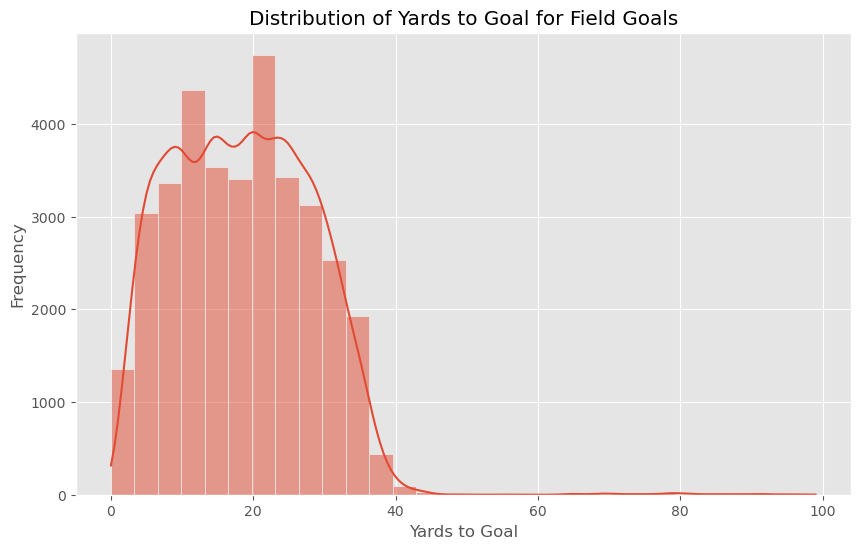

In [35]:
# plot the distirbutoin of yards_to_Goal when was_field_goal is True
plt.figure(figsize=(10, 6))
sns.histplot(fg_attempts['yards_to_goal'], bins=30, kde=True)
plt.title('Distribution of Yards to Goal for Field Goals')
plt.xlabel('Yards to Goal')
plt.ylabel('Frequency')
plt.show() 

In [36]:
id_cols = ['season', 'week', 'play_id', 'drive_id', 'game_id', 'drive_number', 
           'play_number', 'offense', 'defense']
features = [
    'offense_timeouts', 'defense_timeouts','yards_to_goal','score_diff',
    'seconds_remaining', 'pct_game_played', 'diff_time_ratio', 
    'is_home_team', 'grass',
    'is_redzone', 'is_goal_to_go', 'is_blowout',
    'elevation', 'offense_elo', 'defense_elo',
    'temperature', 'wind_speed', 'precipitation',
    'offense_last12_fg_attempts', 'offense_last12_total_poe',
    'offense_last12_longest_fg', 'offense_last12_total_poe_gaussian',
    'offense_last6_fg_attempts', 'offense_last6_total_poe',
    'offense_last6_longest_fg', 'offense_last6_total_poe_gaussian',
    'game_winning_or_tieing_fg', 'tie_or_take_lead'
]
outcome_cols =['fg_outcome', 'fg_made', 'fg_missed', 'fg_blocked']

fg_attempts = (
    fg_attempts
    .query('0 <= yards_to_goal <= 48') # Max 65 yard FG
    .rename(columns={'id': 'play_id'})
    .assign(
        offense_timeouts = lambda x: np.where(x.offense_timeouts == -1, 0, x.offense_timeouts),
        defense_timeouts = lambda x: np.where(x.defense_timeouts == -1, 0, x.defense_timeouts),
    )
    .query('0 < yards_to_goal < 100 and 0 < distance < 100 and '
           '0 <= offense_timeouts <= 3 and 0 <= defense_timeouts <= 3 and '
           '0 <= clock_minutes <= 15 and 0 <= clock_seconds < 59')
    .assign(
        score_diff = lambda x: x['offense_score'] - x['defense_score'],
        seconds_remaining = lambda x: (
            (4 * 15 * 60) - # total game time in seconds
            ((x['period'] - 1) * 15 * 60) - # elapsed quarters in seconds
            (15 * 60 - (x['clock_minutes'] * 60 + x['clock_seconds'])) 
        )
    )
    .assign(
        pct_game_played = lambda x: (4 * 15 * 60 - x['seconds_remaining']) / (4 * 15 * 60),
        diff_time_ratio = lambda x: x['score_diff'] * np.exp(4 * (3600 - x['seconds_remaining']) / 3600),
        is_redzone=lambda x: (x['yards_to_goal'] <= 20).astype(int),
        is_goal_to_go=lambda x: (x['yards_to_goal'] <= x['distance']).astype(int),
        is_blowout=lambda x: (x['score_diff'] >= 21).astype(int),
    )
    .assign(
        fg_made=lambda x: (x['fg_outcome'] == 'good').astype(int),
        fg_missed=lambda x: (x['fg_outcome'] == 'missed').astype(int),
        fg_blocked=lambda x: (x['fg_outcome'] == 'blocked').astype(int)
    )
    .merge(
        games[['id','season','week','venue_id','home_team','neutral_site']]
            .rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .merge(
        venues[['id','elevation','grass']].rename(columns={'id': 'venue_id'}),
        on='venue_id',
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'elo']]
            .rename(columns={
                'team': 'offense',
                'elo': 'offense_elo'
            }),
        left_on=['season', 'week', 'offense'],
        right_on=['season', 'week', 'offense'],
        how='left'
    )
    .merge(
        elo[['season', 'week', 'team', 'elo']]
            .rename(columns={
                'team': 'defense',
                'elo': 'defense_elo'
            }),
        left_on=['season', 'week', 'defense'],
        right_on=['season', 'week', 'defense'],
        how='left'
    )
    .merge(
        weather[['id','temperature','wind_speed','precipitation','game_indoors']]
            .rename(columns={'id': 'game_id'}),
        on='game_id',
        how='left'
    )
    .assign(
        wind_speed=lambda x: np.where(
            x.game_indoors, 0, x.wind_speed.fillna(int(x.wind_speed.mean()))
        ),
        precipitation=lambda x: np.where(
            x.game_indoors, 0, x.precipitation.fillna(int(x.precipitation.mean()))
        ),
        temperature=lambda x: np.where(
            x.game_indoors, 70, x.temperature.fillna(int(x.temperature.mean()))
        ),
        grass = lambda x: x.grass.fillna(False).astype(int),
        is_home_team=lambda x: np.where(
            x.neutral_site, 0, np.where(x.offense == x.home_team, 1, -1)
        ),
    )
    .merge(
        fg_poe_rolling.drop(columns=['season', 'week','season_type'])
            .rename(columns={
                'team': 'offense',
                'last12_fg_attempts': 'offense_last12_fg_attempts',
                'last12_total_poe': 'offense_last12_total_poe',
                'last12_longest_fg': 'offense_last12_longest_fg',
                'last12_total_poe_gaussian': 'offense_last12_total_poe_gaussian',
                'last6_fg_attempts': 'offense_last6_fg_attempts',
                'last6_total_poe': 'offense_last6_total_poe',
                'last6_longest_fg': 'offense_last6_longest_fg',
                'last6_total_poe_gaussian': 'offense_last6_total_poe_gaussian'
            }),
        on=['game_id', 'offense'],
        how='left'
    )
    .dropna(subset=['offense_last12_fg_attempts', 'offense_last6_fg_attempts'])
    .assign(
        tie_or_take_lead=lambda x: np.where(
            (x['score_diff'] >= -3) & (x['score_diff'] <= 0),
            1, 0
        ),
        game_winning_or_tieing_fg=lambda x: np.where(
            (x['pct_game_played'] >= .9916) & (x['tie_or_take_lead'] == 1), # Final 30 seconds
            1, 0
        )
    )
    [id_cols + features + outcome_cols]
)
fg_attempts['elevation'] = (
    fg_attempts['elevation']
    .fillna(int(fg_attempts.elevation.astype(float).mean()))
    .astype(float)  
)
fg_attempts['pressure_rating'] = np.select(
    [
        (fg_attempts['pct_game_played'] >= (58 / 60)) & (fg_attempts['score_diff'] >= -3) & (fg_attempts['score_diff'] <= 0),  # tie or take the lead, last 2 min
        (fg_attempts['pct_game_played'] >= (55 / 60)) & (fg_attempts['score_diff'] >= -3) & (fg_attempts['score_diff'] <= 0),  # tie or take the lead, last 5 - 2 min
        (fg_attempts['pct_game_played'] >= (50 / 60)) & (fg_attempts['score_diff'] >= -3) & (fg_attempts['score_diff'] <= 0),  # tie or take the lead, last 10 - 5 min
        (fg_attempts['pct_game_played'] >= (45 / 60)) & (fg_attempts['score_diff'] >= -3) & (fg_attempts['score_diff'] <= 0),  # tie or take the lead, last 15 - 10 min
    ],
    [4, 3, 2, 1],
    default=0
)
fg_attempts.head()

/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_24317/2389998874.py:96: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  grass = lambda x: x.grass.fillna(False).astype(int),


,season,week,play_id,drive_id,game_id,drive_number,play_number,offense,defense,offense_timeouts,defense_timeouts,yards_to_goal,score_diff,seconds_remaining,pct_game_played,diff_time_ratio,is_home_team,grass,is_redzone,is_goal_to_go,is_blowout,elevation,offense_elo,defense_elo,temperature,wind_speed,precipitation,offense_last12_fg_attempts,offense_last12_total_poe,offense_last12_longest_fg,offense_last12_total_poe_gaussian,offense_last6_fg_attempts,offense_last6_total_poe,offense_last6_longest_fg,offense_last6_total_poe_gaussian,game_winning_or_tieing_fg,tie_or_take_lead,fg_outcome,fg_made,fg_missed,fg_blocked,pressure_rating
0,2013,1,333610120120,33361012012,333610120,12,11,Maryland,Marshall,3.0,2.0,14,-4,1880,0.477778,-27.042386,0,0,1,0,0,10.749901,1921.246102,1703.121251,46.0,9.2,0.0,23.0,3.24,33.0,2.21228,9.0,-0.08,25.0,-0.850670,0,0,good,1,0,0,0
1,2013,1,333610120075,33361012008,333610120,8,10,Maryland,Marshall,3.0,3.0,7,-4,2496,0.306667,-13.639378,0,0,1,1,0,10.749901,1921.246102,1703.121251,46.0,9.2,0.0,23.0,3.24,33.0,2.21228,9.0,-0.08,25.0,-0.850670,0,0,good,1,0,0,0
2,2013,1,332430120241,33243012025,332430120,25,10,Maryland,Florida International,3.0,3.0,5,33,760,0.788889,774.380316,1,0,1,1,1,32.687481,1921.246102,1388.832367,87.4,4.7,0.0,17.0,-5.11,34.0,-5.11000,7.0,-1.39,30.0,-3.253059,0,0,good,1,0,0,0
3,2013,1,332430120014,33243012002,332430120,2,4,Maryland,Florida International,2.0,3.0,7,6,3315,0.079167,8.235270,1,0,1,0,0,32.687481,1921.246102,1388.832367,87.4,4.7,0.0,17.0,-5.11,34.0,-5.11000,7.0,-1.39,30.0,-3.253059,0,0,good,1,0,0,0
4,2013,1,332430120009,33243012001,332430120,1,8,Maryland,Florida International,2.0,3.0,2,3,3408,0.053333,3.713392,1,0,1,1,0,32.687481,1921.246102,1388.832367,87.4,4.7,0.0,17.0,-5.11,34.0,-5.11000,7.0,-1.39,30.0,-3.253059,0,0,good,1,0,0,0


# Model 1: Field Goal Blocked Model
Did not see an improvement over the baseline when using a model to predict if a fg is blocked. However, there is a relationship between kick distance and block rate. Modeled the probability with the linear relationship between kick distance and if the FG was blocked. For field goal distances over 60 yards, a block rate of 5.9% is used.

In [16]:
feature_names = [
    'offense_timeouts',
    'defense_timeouts',
    'yards_to_goal',
    'score_diff',
    'seconds_remaining',
    'pct_game_played',
    'diff_time_ratio',
    'is_redzone',
    'is_goal_to_go',
    'is_blowout',
    'elevation',
    'offense_elo',
    'defense_elo',
    'temperature',
    'wind_speed',
    'precipitation',
    'offense_last12_fg_attempts',
    'offense_last12_total_poe',
    'offense_last12_longest_fg',
    'offense_last12_total_poe_gaussian',
    'offense_last6_fg_attempts',
    'offense_last6_total_poe',
    'offense_last6_longest_fg',
    'offense_last6_total_poe_gaussian',
]

target_variable = 'fg_blocked'

data = fg_attempts[feature_names + [target_variable]].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data[target_variable]
)
test_x, test_y = test_data[feature_names], test_data[target_variable]

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], 
    train_data[target_variable], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data[target_variable]
)

In [17]:
train_y.value_counts(normalize=True)

fg_blocked
0    0.968814
1    0.031186
Name: proportion, dtype: float64

In [18]:
valid_y.value_counts(normalize=True)

fg_blocked
0    0.968767
1    0.031233
Name: proportion, dtype: float64

In [19]:
test_y.value_counts(normalize=True)

fg_blocked
0    0.968805
1    0.031195
Name: proportion, dtype: float64

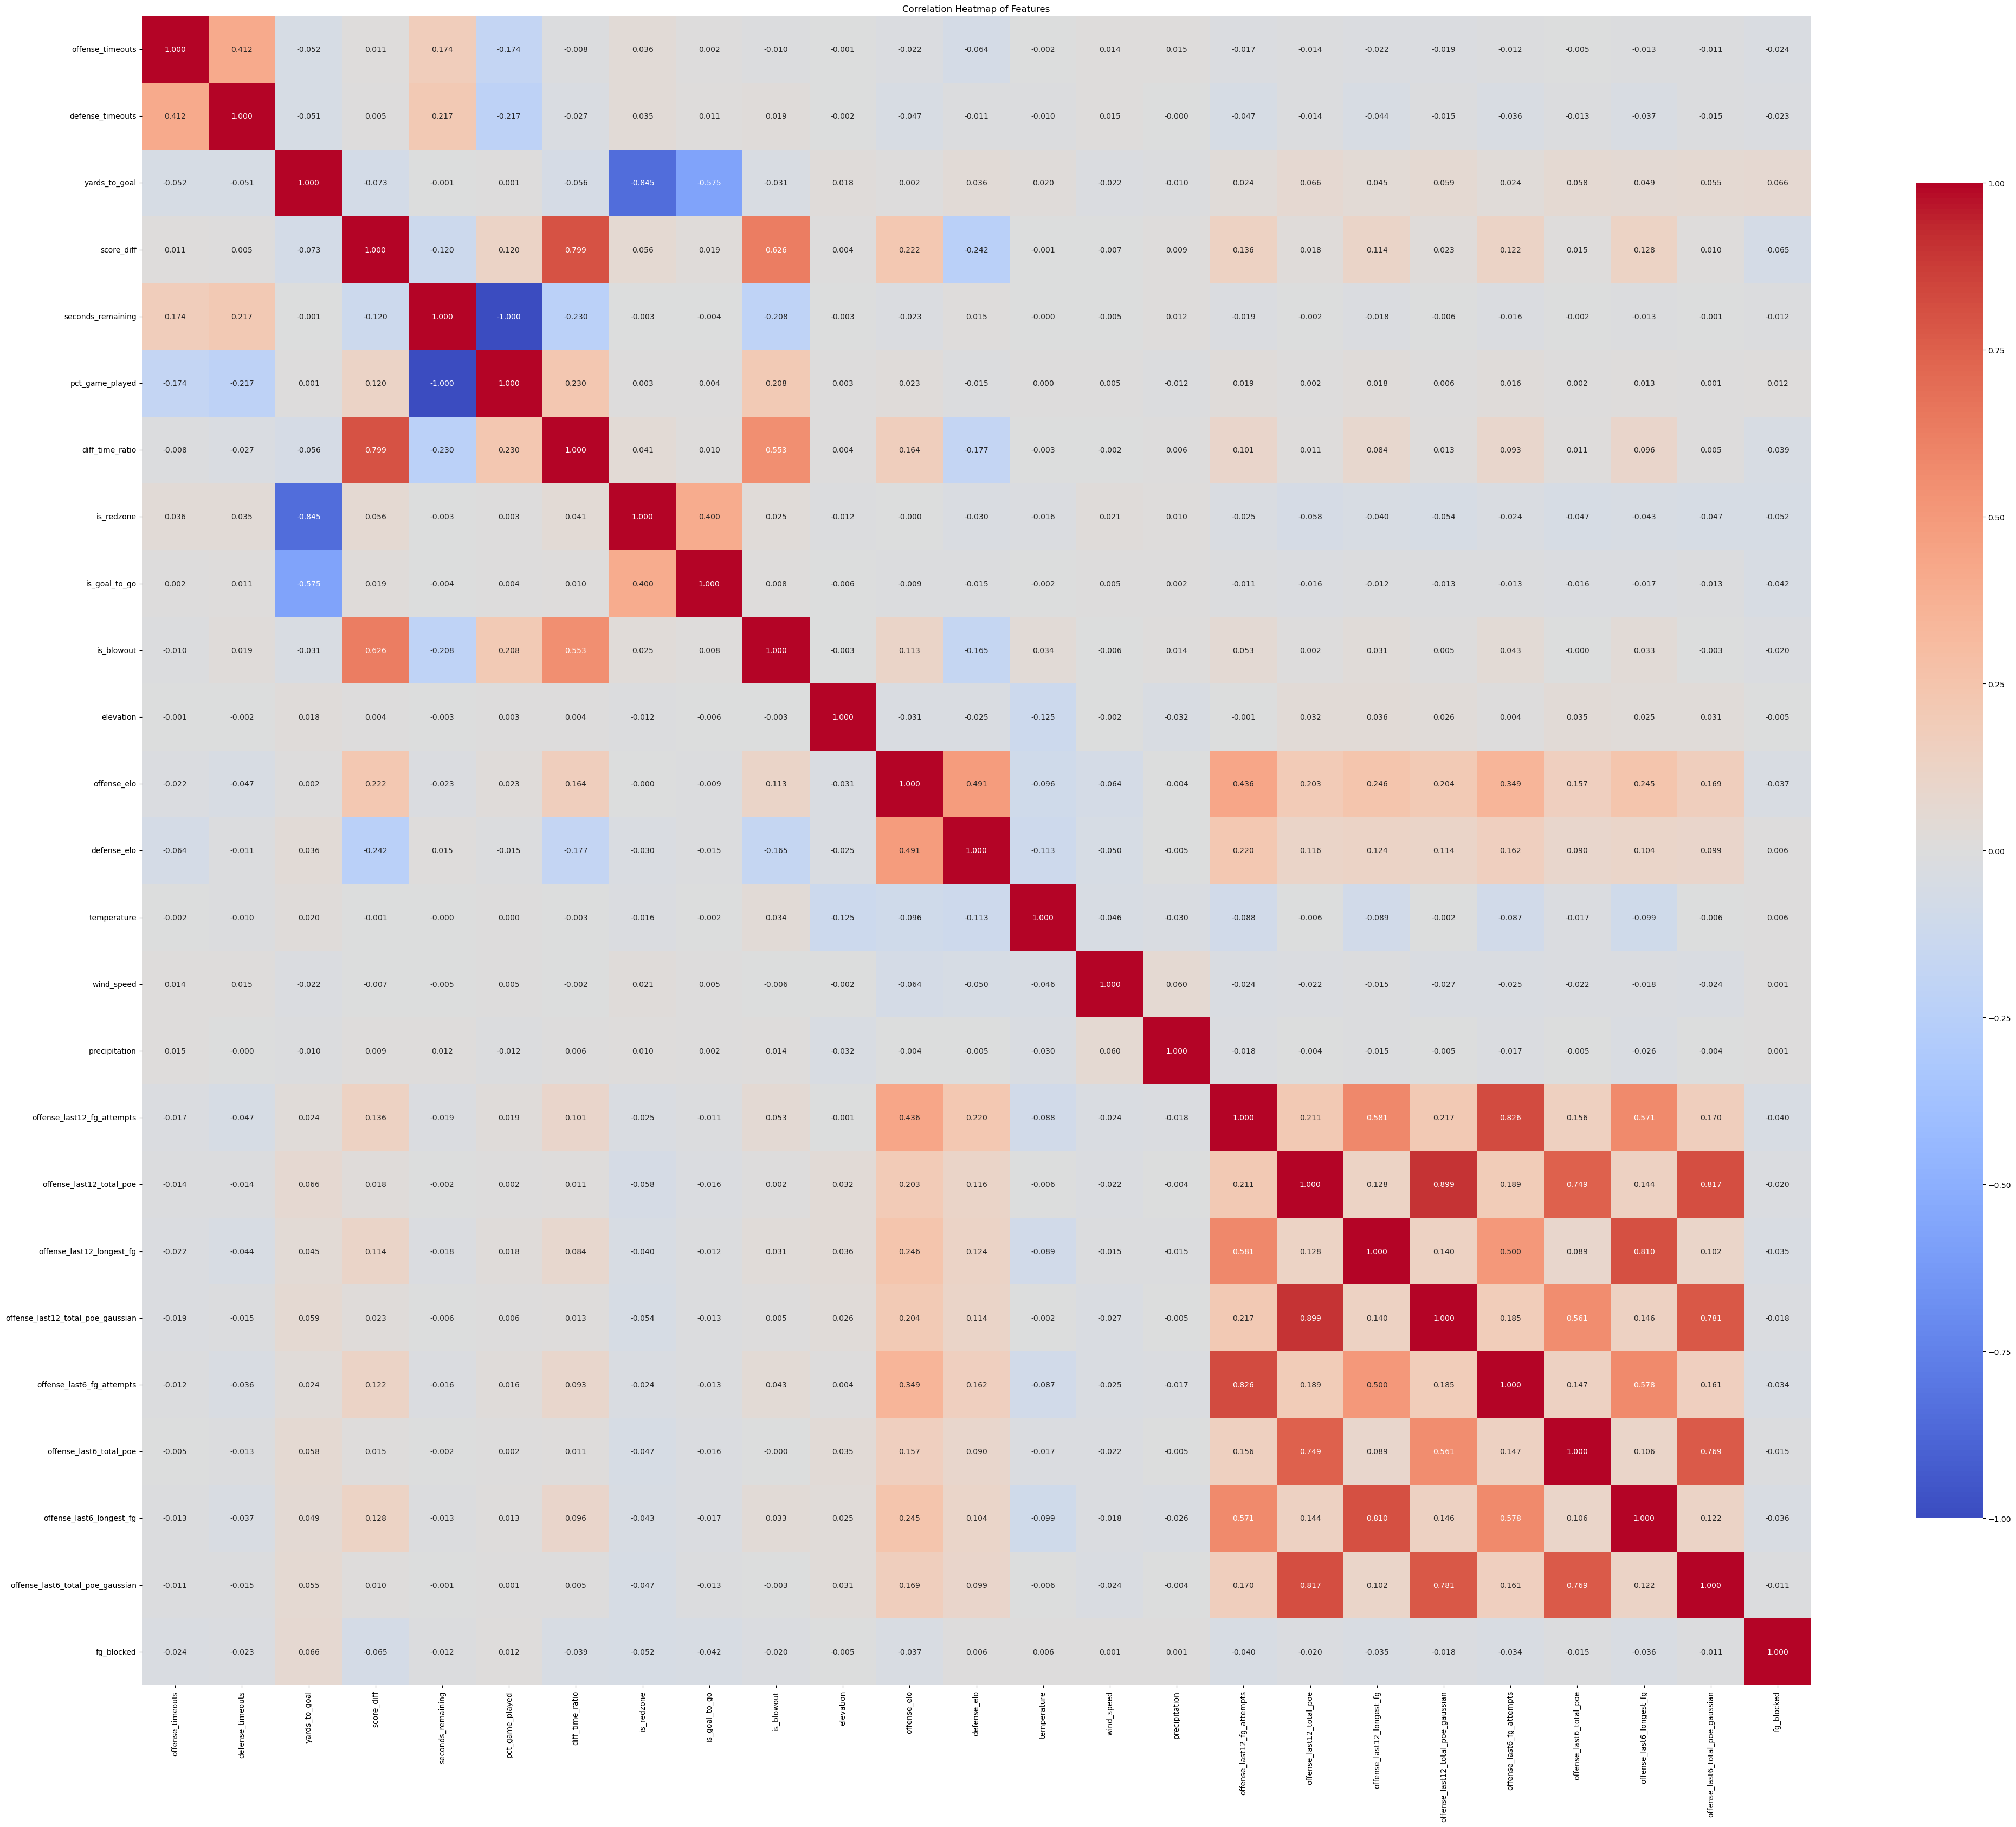

In [20]:
# correlation heatmap
plt.figure(figsize=(50, 40))
sns.heatmap(
    fg_attempts[feature_names + [target_variable]].corr(),
    annot=True, 
    fmt=".3f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [21]:
fg_attempts.fg_blocked.value_counts(normalize=True)

fg_blocked
0    0.968805
1    0.031195
Name: proportion, dtype: float64

In [22]:
from sklearn.utils.class_weight import compute_sample_weight
train_sample_weights = compute_sample_weight(class_weight='balanced', y=train_y)
valid_sample_weights = compute_sample_weight(class_weight='balanced', y=valid_y)

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
    
    # Calculate multiclass log loss
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y, weight=train_sample_weights)
dvalid = xgb.DMatrix(valid_x, label=valid_y, weight=valid_sample_weights)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="blocked_fg_optimization",
    direction="minimize", 
    load_if_exists=True,
    sampler=sampler
)
study.optimize(
    lambda trial: objective(trial, dtrain, dvalid), 
    n_trials=30,
    show_progress_bar=True
)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'nthread': -1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'booster': 'gbtree',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

  0%|          | 0/30 [00:00<?, ?it/s]

Number of boosted rounds: 1


In [23]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, log_loss

# Helper to compute all metrics
def evaluate_set(name, X, y_true):
    dmatrix = xgb.DMatrix(X)
    y_proba = final_model.predict(dmatrix)
    y_pred = np.where(y_proba > 0.5, 1, 0)

    bal_acc = balanced_accuracy_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    ce_loss = log_loss(y_true, y_proba)

    print(f"\n=== {name.upper()} SET METRICS ===")
    print(f"Balanced Accuracy : {bal_acc:.4f}")
    print(f"Accuracy          : {acc:.4f}")
    print(f"Macro F1 Score    : {macro_f1:.4f}")
    print(f"Log Loss          : {ce_loss:.4f}")

# Evaluate each split
evaluate_set("Train", train_x, train_y)
evaluate_set("Validation", valid_x, valid_y)
evaluate_set("Test", test_x, test_y)


=== TRAIN SET METRICS ===
Balanced Accuracy : 0.9420
Accuracy          : 0.9252
Macro F1 Score    : 0.7022
Log Loss          : 0.2546

=== VALIDATION SET METRICS ===
Balanced Accuracy : 0.5573
Accuracy          : 0.8856
Macro F1 Score    : 0.5203
Log Loss          : 0.3158

=== TEST SET METRICS ===
Balanced Accuracy : 0.5607
Accuracy          : 0.8865
Macro F1 Score    : 0.5221
Log Loss          : 0.3170


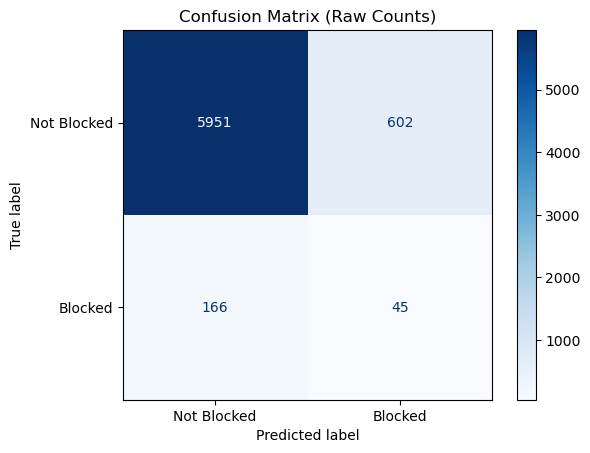

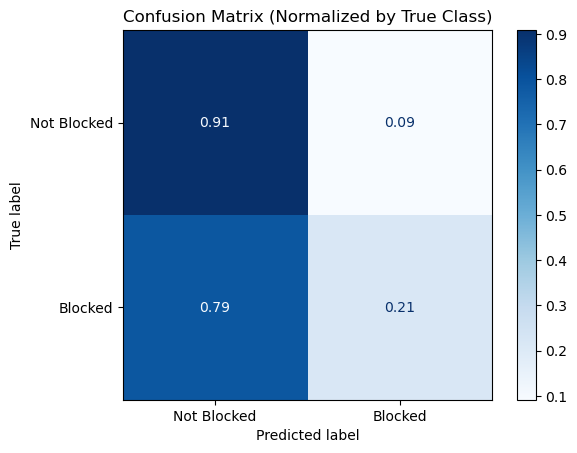

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_names = ['Not Blocked', 'Blocked']

# Get predicted labels on test set
dtest = xgb.DMatrix(test_x)
y_test_proba = final_model.predict(dtest)
y_test_pred = np.where(y_test_proba > 0.5, 1, 0)

# Compute confusion matrix
cm = confusion_matrix(test_y, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# Plot non-normalized
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (Raw Counts)")
plt.show()

# Plot normalized by true labels (per-class recall)
cm_normalized = confusion_matrix(test_y, y_test_pred, normalize='true')
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
disp_norm.plot(cmap='Blues', values_format=".2f")
plt.title("Confusion Matrix (Normalized by True Class)")
plt.show()

In [25]:
from sklearn.dummy import DummyClassifier

# Fit a dummy classifier that always predicts class probabilities
dummy = DummyClassifier(strategy="prior")
dummy.fit(train_x, train_y)  # train_y should be encoded (0, 1, 2, 3)

# Evaluate on test set
dummy_probs = dummy.predict_proba(test_x)
dummy_bal_acc = balanced_accuracy_score(test_y, dummy.predict(test_x))
dummy_acc = accuracy_score(test_y, dummy.predict(test_x))
dummy_macro_f1 = f1_score(test_y, dummy.predict(test_x), average='macro')
dummy_ce_loss = log_loss(test_y, dummy_probs) 

print("\n=== DUMMY CLASSIFIER METRICS ===")
print(f"Balanced Accuracy : {dummy_bal_acc:.4f}")
print(f"Accuracy          : {dummy_acc:.4f}")
print(f"Macro F1 Score    : {dummy_macro_f1:.4f}")
print(f"Log Loss          : {dummy_ce_loss:.4f}")


=== DUMMY CLASSIFIER METRICS ===
Balanced Accuracy : 0.5000
Accuracy          : 0.9688
Macro F1 Score    : 0.4921
Log Loss          : 0.1389


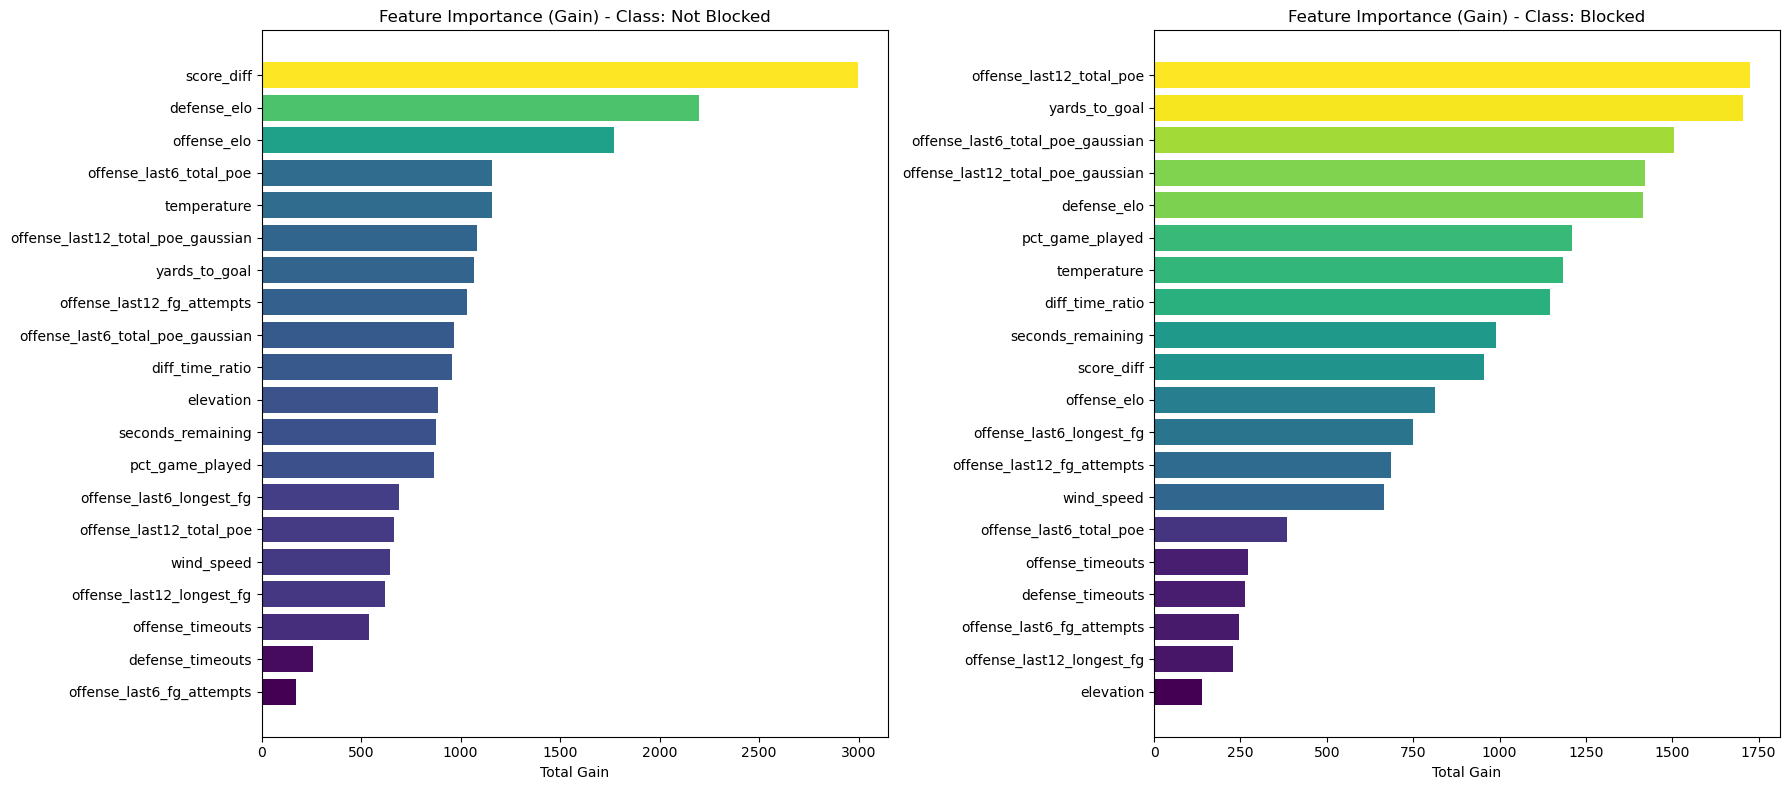

In [26]:
import matplotlib.cm as cm

num_classes = 2
class_names = ['Not Blocked', 'Blocked']
trees_df = final_model.trees_to_dataframe()

fig, axes = plt.subplots(1,2, figsize=(18, 8))
axes = axes.flatten()

for class_id in range(num_classes):
    class_trees = trees_df[trees_df['Tree'] % num_classes == class_id]
    class_gain = (
        class_trees[class_trees['Feature'] != 'Leaf']
        .groupby('Feature')['Gain']
        .sum()
        .sort_values(ascending=False)
    )
    top_features = class_gain[:20]
    norm = plt.Normalize(top_features.min(), top_features.max())
    colors = cm.viridis(norm(top_features.values))

    ax = axes[class_id]
    ax.barh(top_features.index, top_features.values, color=colors)
    ax.set_title(f"Feature Importance (Gain) - Class: {class_names[class_id]}")
    ax.invert_yaxis()
    ax.set_xlabel("Total Gain")

plt.tight_layout()
plt.show()


100%|██████████| 3/3 [00:00<00:00,  8.87it/s]
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_24317/506683757.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


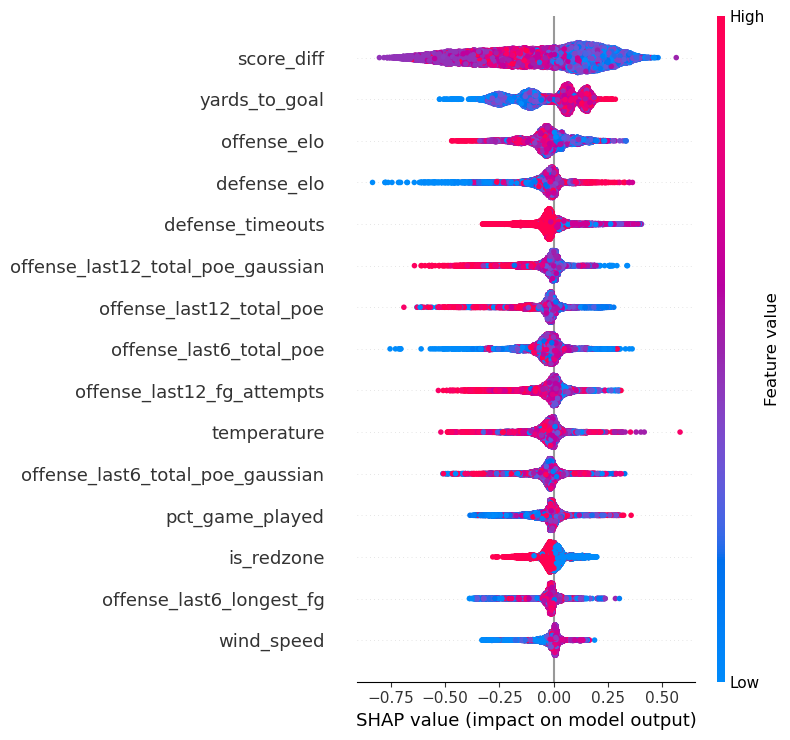

In [27]:
chunk_size = 10000
n_row = 100000

background = train_data[feature_names].iloc[:n_row]
explainer = shap.TreeExplainer(final_model)

num_rows = background.shape[0]

shap_values = []

for i in tqdm(range(0, num_rows, chunk_size)):
    chunk = background.iloc[i:i+chunk_size]
    shap_chunk = explainer(chunk)
    shap_values.append(shap_chunk.values)

shap_values = np.concatenate(shap_values, axis=0)

shap.summary_plot(shap_values, 
                 background,
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

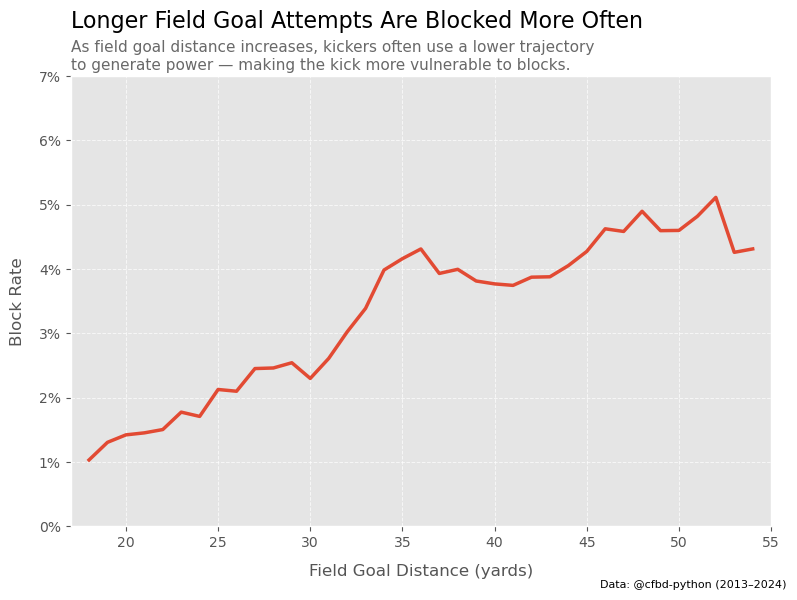

In [28]:
fg_attempts['fg_distance'] = fg_attempts['yards_to_goal'] + 17

rolling = (
    fg_attempts
    .sort_values('fg_distance')
    .groupby('fg_distance')
    .agg(blocked_rate=('fg_blocked', 'mean'),
         count=('fg_blocked', 'count'))
    .rolling(window=5, min_periods=5)
    .mean()
    .reset_index()
    .assign(
        fg_distance=lambda x: x.fg_distance - 4,
    )
    .query('fg_distance < 55')
)

plt.style.use('ggplot')

plt.figure(figsize=(8, 6))

ax = sns.lineplot(x='fg_distance', y='blocked_rate', data=rolling, 
                 linewidth=2.5, color='#E24A33')

# Title + subtitle separation
ax.set_title('Longer Field Goal Attempts Are Blocked More Often', 
             fontsize=16, pad=12, loc='left', y=1.07)

# Add subtitle manually using text
plt.text(
    17, 0.071,# Adjust these coords to best fit your layout
    'As field goal distance increases, kickers often use a lower trajectory\n'
    'to generate power — making the kick more vulnerable to blocks.',
    fontsize=11,
    color='dimgray'
)

ax.set_xlabel('Field Goal Distance (yards)', fontsize=12, labelpad=10)
ax.set_ylabel('Block Rate', fontsize=12, labelpad=10)

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
ax.set_xticks(range(0, 56, 5))
ax.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)

ax.set_xlim(17, 55)
ax.set_ylim(0, 0.07)

plt.figtext(
    0.99, 0.01,
    'Data: @cfbd-python (2013–2024)', 
    horizontalalignment='right', 
    fontsize=8, 
)

plt.tight_layout()
plt.show()

In [29]:
fg_attempts['fg_distance_bin'] = (fg_attempts['fg_distance'] // 5) * 5

# Calculate mean blocked rate
blocked_rate = (
    fg_attempts
    .groupby('fg_distance_bin')['fg_blocked']
    .mean()
    .reset_index()
    .rename(columns={'fg_distance_bin': 'fg_distance', 'fg_blocked': 'blocked_rate'})
)

# Calculate count per bin
bin_counts = (
    fg_attempts
    .groupby('fg_distance_bin')
    .size()
    .reset_index(name='count')
    .rename(columns={'fg_distance_bin': 'fg_distance'})
)

# Merge the two
fg_distance_blocked_rate = (
    pd.merge(blocked_rate, bin_counts, on='fg_distance')
    .query('fg_distance <= 55')
    .rename(columns={'fg_distance': 'fg_distance_bin_center'})
    .assign(
        fg_distance_bin_center=lambda x: x.fg_distance_bin_center + 2.5,  # Center the bin
    )
)
fg_distance_blocked_rate

,fg_distance_bin_center,blocked_rate,count
0,17.5,0.007987,626
1,22.5,0.014360,4596
2,27.5,0.021157,5341
3,32.5,0.023239,5465
4,37.5,0.041757,5508
5,42.5,0.037864,5467
6,47.5,0.042394,4411
7,52.5,0.047505,2084
8,57.5,0.054983,291


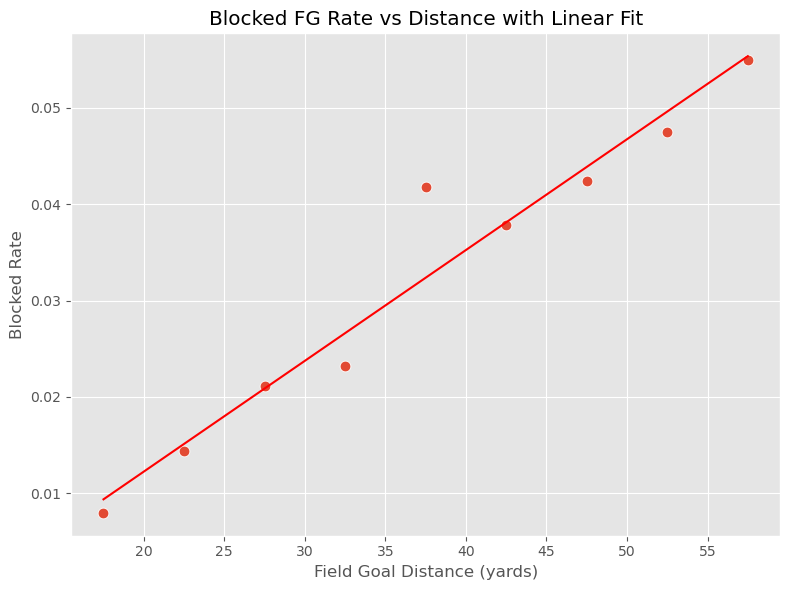

Intercept (b): -0.01070
Slope (m): 0.00115


In [30]:
from scipy.stats import linregress

# Fit a line: blocked_rate = m * fg_distance + b
slope, intercept, r_value, p_value, std_err = linregress(
    fg_distance_blocked_rate['fg_distance_bin_center'], 
    fg_distance_blocked_rate['blocked_rate']
)

# Add fitted line to the DataFrame
fg_distance_blocked_rate['predicted_blocked_rate'] = (
    slope * fg_distance_blocked_rate['fg_distance_bin_center'] + intercept
)

# Optional: visualize
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=fg_distance_blocked_rate, x='fg_distance_bin_center', y='blocked_rate', s=60)
sns.lineplot(data=fg_distance_blocked_rate, x='fg_distance_bin_center', y='predicted_blocked_rate', color='red')
plt.title('Blocked FG Rate vs Distance with Linear Fit')
plt.xlabel('Field Goal Distance (yards)')
plt.ylabel('Blocked Rate')
plt.grid(True)
plt.tight_layout()
plt.show()

# For your model:
print(f"Intercept (b): {intercept:.5f}")
print(f"Slope (m): {slope:.5f}")

# Model 2: Field Goal Make Model

In [103]:
feature_names = [
    # 'season',
    # 'offense_timeouts',
    # 'defense_timeouts',
    'yards_to_goal',
    # 'score_diff',
    # 'seconds_remaining',
    # 'pct_game_played',
    # 'diff_time_ratio',
    # 'is_home_team',
    # 'grass',
    'pressure_rating',
    # 'is_redzone',
    # 'is_goal_to_go',
    # 'is_blowout',
    'elevation',
    'offense_elo',
    # 'defense_elo',
    'temperature',
    'wind_speed',
    # 'precipitation',
    # 'offense_last12_fg_attempts',
    # 'offense_last12_total_poe',
    # 'offense_last12_longest_fg',
    'offense_last12_total_poe_gaussian',
    # 'offense_last6_fg_attempts',
    # 'offense_last6_total_poe',
    # 'offense_last6_longest_fg',
    # 'offense_last6_total_poe_gaussian',
    # 'game_winning_or_tieing_fg',
    'tie_or_take_lead'
]

target_variable = 'fg_made'

data = fg_attempts[feature_names + [target_variable]].copy()

SEED = 2

# Split the data into and 80-20 train-test split
train_data, test_data = train_test_split(
    data,  
    test_size=0.2, 
    random_state=SEED, 
    stratify=data[target_variable]
)
test_x, test_y = test_data[feature_names], test_data[target_variable]

# # Split into 80-20 train val set by game_id
train_x, valid_x, train_y, valid_y = train_test_split(
    train_data[feature_names], 
    train_data[target_variable], 
    test_size=0.2, 
    random_state=SEED, 
    stratify=train_data[target_variable]
)

In [104]:
train_y.value_counts(normalize=True)

fg_made
1    0.734106
0    0.265894
Name: proportion, dtype: float64

In [105]:
valid_y.value_counts(normalize=True)

fg_made
1    0.73406
0    0.26594
Name: proportion, dtype: float64

In [106]:
test_y.value_counts(normalize=True)

fg_made
1    0.734033
0    0.265967
Name: proportion, dtype: float64

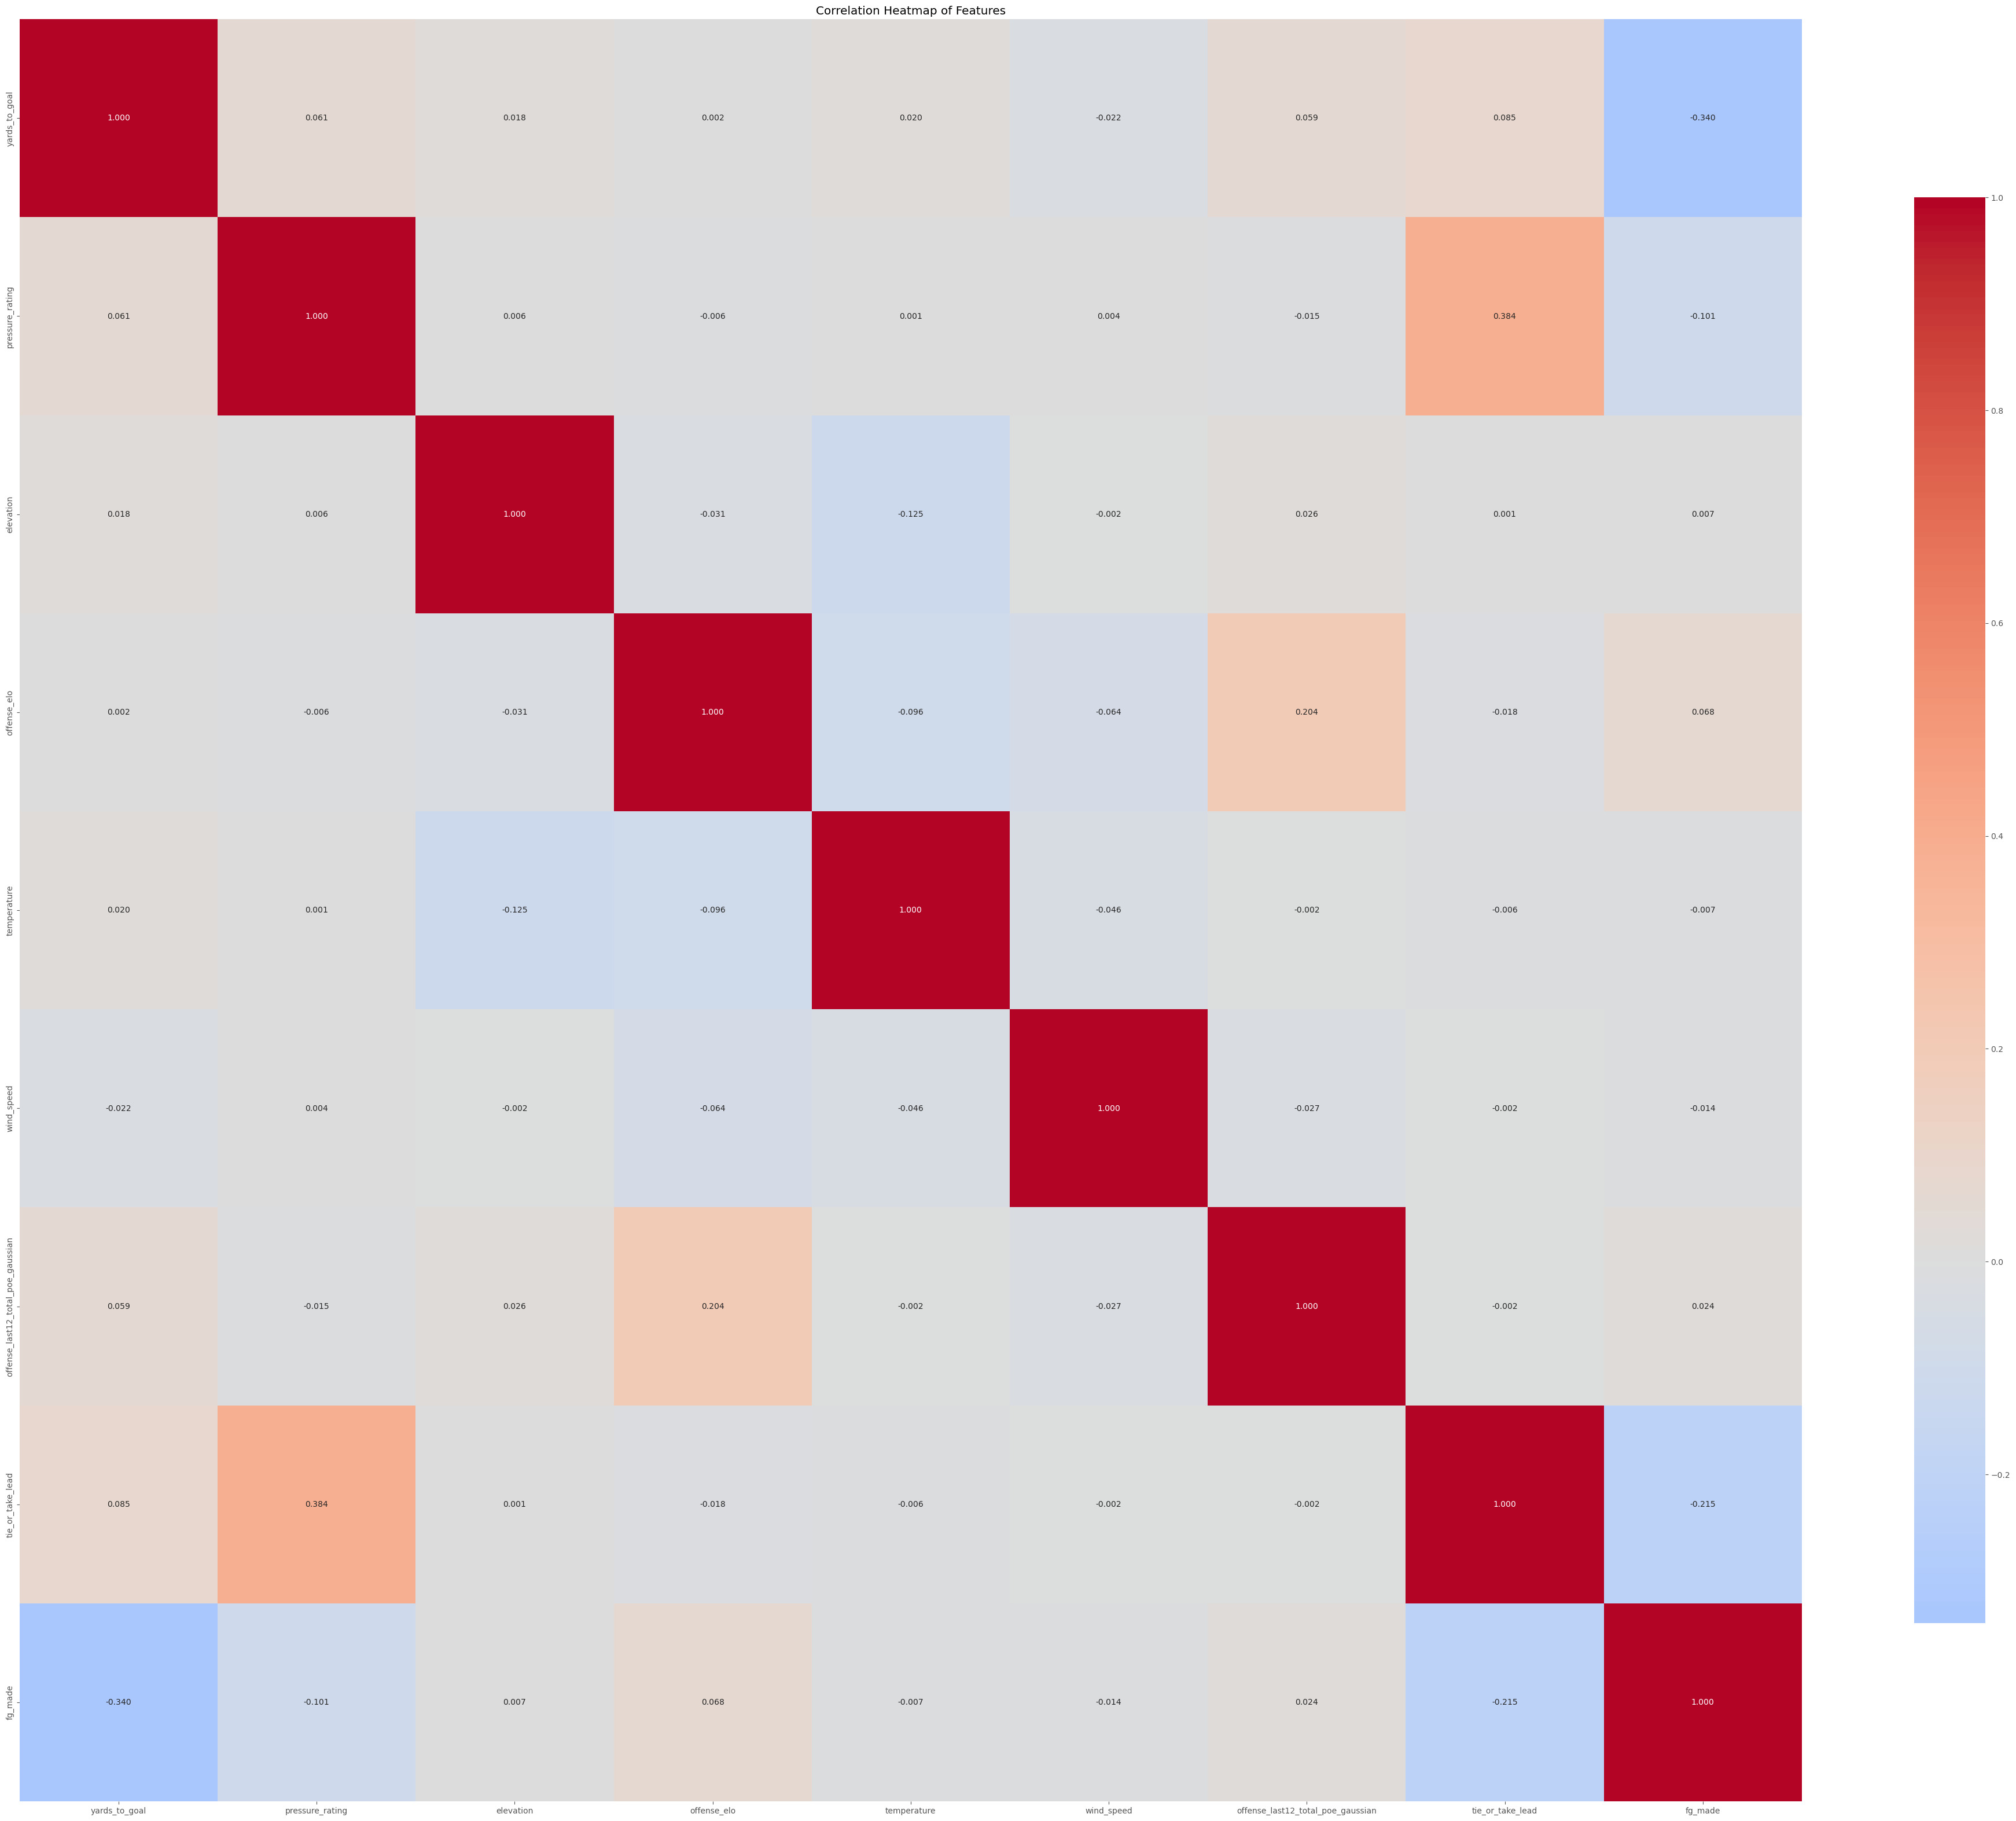

In [107]:
# correlation heatmap
plt.figure(figsize=(50, 40))
sns.heatmap(
    fg_attempts[feature_names + [target_variable]].corr(),
    annot=True, 
    fmt=".3f", 
    cmap='coolwarm', 
    center=0,
    square=True,
    cbar_kws={"shrink": .8}
)
plt.title('Correlation Heatmap of Features')
plt.show()

In [108]:
fg_attempts.fg_made.value_counts(normalize=True)

fg_made
1    0.734084
0    0.265916
Name: proportion, dtype: float64

In [124]:
feature_names

['yards_to_goal',
 'pressure_rating',
 'elevation',
 'offense_elo',
 'temperature',
 'wind_speed',
 'offense_last12_total_poe_gaussian',
 'tie_or_take_lead']

In [ ]:
# from sklearn.utils.class_weight import compute_sample_weight
# train_sample_weights = compute_sample_weight(class_weight='balanced', y=train_y)
# valid_sample_weights = compute_sample_weight(class_weight='balanced', y=valid_y)

optuna.logging.set_verbosity(optuna.logging.CRITICAL)
SEED = 22
np.random.seed(SEED)

monotonic_constraints_map = {
    # "season": 1,
    "yards_to_goal": -1,
    # "is_home_team": 1,
    "pressure_rating": -1,
    "elevation": 1,
    "offense_elo": 1,
    # "defense_elo": -1,
    "temperature": 1,
    "wind_speed": -1,
    # "precipitation": -1,
    "offense_last12_total_poe_gaussian": 1,
    # "game_winning_or_tieing_fg": -1,
    "tie_or_take_lead": -1,

}
monotonic_constraints = tuple([monotonic_constraints_map.get(feature, 0) for feature in feature_names])


# Objective function for Optuna
def objective(trial, dtrain, dvalid):
    param = {
        "nthread": -1,
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "booster": "gbtree",
        "monotone_constraints": monotonic_constraints,
        "lambda": trial.suggest_float("lambda", 1e-5, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-5, 10.0, log=True),
        "eta": trial.suggest_float("eta", 0.05, 0.3, step=0.01),
        "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
        "min_child_weight": trial.suggest_float("min_child_weight", .5, 10, step=.5),
        "gamma": trial.suggest_float("gamma", 1e-8, 5.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "seed": SEED,
    }
    
    bst = xgb.train(
        param, 
        dtrain,
        num_boost_round=500,
        evals=[(dvalid, "eval")],
        early_stopping_rounds=10,
        verbose_eval=False,
    )
    preds = bst.predict(dvalid)
    
    # Calculate multiclass log loss
    return log_loss(valid_y, preds)

# Create DMatrix objects
dtrain = xgb.DMatrix(train_x, label=train_y) #, weight=train_sample_weights)
dvalid = xgb.DMatrix(valid_x, label=valid_y) #, weight=valid_sample_weights)

# Run Optuna optimization
sampler = optuna.samplers.TPESampler(seed=SEED)
study = optuna.create_study(
    study_name="fg_make_optimization",
    direction="minimize", 
    load_if_exists=False,
    sampler=sampler
)
study.optimize(
    lambda trial: objective(trial, dtrain, dvalid), 
    n_trials=50,
    show_progress_bar=True
)

# Train final model with best parameters
best_params = {
    **study.best_trial.params,
    'monotone_constraints': monotonic_constraints,
    'nthread': -1,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'booster': 'gbtree',
    'seed': SEED,
}

final_model = xgb.train(
    best_params, 
    dtrain,
    num_boost_round=500,
    evals=[(dvalid, "eval")],
    early_stopping_rounds=10,
    verbose_eval=False
)
print(f"Number of boosted rounds: {final_model.best_iteration}")

  0%|          | 0/50 [00:00<?, ?it/s]

Number of boosted rounds: 91


In [110]:
# neither
from sklearn.metrics import balanced_accuracy_score, accuracy_score, f1_score, log_loss, brier_score_loss

# Helper to compute all metrics
def evaluate_set(name, X, y_true):
    dmatrix = xgb.DMatrix(X)
    y_proba = final_model.predict(dmatrix)
    y_pred = np.where(y_proba > 0.5, 1, 0)

    bal_acc = balanced_accuracy_score(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average='macro')
    ce_loss = log_loss(y_true, y_proba)
    brier_loss = brier_score_loss(y_true, y_proba)

    print(f"\n=== {name.upper()} SET METRICS ===")
    print(f"Balanced Accuracy : {bal_acc:.4f}")
    print(f"Accuracy          : {acc:.4f}")
    print(f"Macro F1 Score    : {macro_f1:.4f}")
    print(f"Log Loss          : {ce_loss:.4f}")
    print(f"Brier Score Loss  : {brier_loss:.4f}")

# Evaluate each split
evaluate_set("Train", train_x, train_y)
evaluate_set("Validation", valid_x, valid_y)
evaluate_set("Test", test_x, test_y)


=== TRAIN SET METRICS ===
Balanced Accuracy : 0.6031
Accuracy          : 0.7633
Macro F1 Score    : 0.6119
Log Loss          : 0.4877
Brier Score Loss  : 0.1608

=== VALIDATION SET METRICS ===
Balanced Accuracy : 0.6038
Accuracy          : 0.7638
Macro F1 Score    : 0.6128
Log Loss          : 0.4934
Brier Score Loss  : 0.1631

=== TEST SET METRICS ===
Balanced Accuracy : 0.6021
Accuracy          : 0.7635
Macro F1 Score    : 0.6106
Log Loss          : 0.5008
Brier Score Loss  : 0.1645


In [111]:
# from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# import matplotlib.pyplot as plt

# class_names = [ 'Missed', 'Made']

# # Get predicted labels on test set
# dtest = xgb.DMatrix(test_x)
# y_test_proba = final_model.predict(dtest)
# y_test_pred = np.where(y_test_proba > 0.5, 1, 0)

# # Compute confusion matrix
# cm = confusion_matrix(test_y, y_test_pred)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

# # Plot non-normalized
# disp.plot(cmap='Blues', values_format='d')
# plt.grid(False)
# plt.title("Confusion Matrix (Raw Counts)")
# plt.show()

# # Plot normalized by true labels (per-class recall)
# cm_normalized = confusion_matrix(test_y, y_test_pred, normalize='true')
# disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
# disp_norm.plot(cmap='Blues', values_format=".2f")
# plt.title("Confusion Matrix (Normalized by True Class)")
# plt.grid(False)
# plt.show()

In [112]:
from sklearn.dummy import DummyClassifier

# Fit a dummy classifier that always predicts class probabilities
dummy = DummyClassifier(strategy="prior")
dummy.fit(train_x, train_y)  # train_y should be encoded (0, 1, 2, 3)

# Evaluate on test set
dummy_probs = dummy.predict_proba(test_x)
dummy_bal_acc = balanced_accuracy_score(test_y, dummy.predict(test_x))
dummy_acc = accuracy_score(test_y, dummy.predict(test_x))
dummy_macro_f1 = f1_score(test_y, dummy.predict(test_x), average='macro')
dummy_ce_loss = log_loss(test_y, dummy_probs) 
dummy_brier_loss = brier_score_loss(test_y, dummy_probs[:, 1])

print("\n=== DUMMY CLASSIFIER METRICS ===")
print(f"Balanced Accuracy : {dummy_bal_acc:.4f}")
print(f"Accuracy          : {dummy_acc:.4f}")
print(f"Macro F1 Score    : {dummy_macro_f1:.4f}")
print(f"Log Loss          : {dummy_ce_loss:.4f}")
print(f"Brier Score Loss  : {dummy_brier_loss:.4f}")


=== DUMMY CLASSIFIER METRICS ===
Balanced Accuracy : 0.5000
Accuracy          : 0.7340
Macro F1 Score    : 0.4233
Log Loss          : 0.5792
Brier Score Loss  : 0.1952


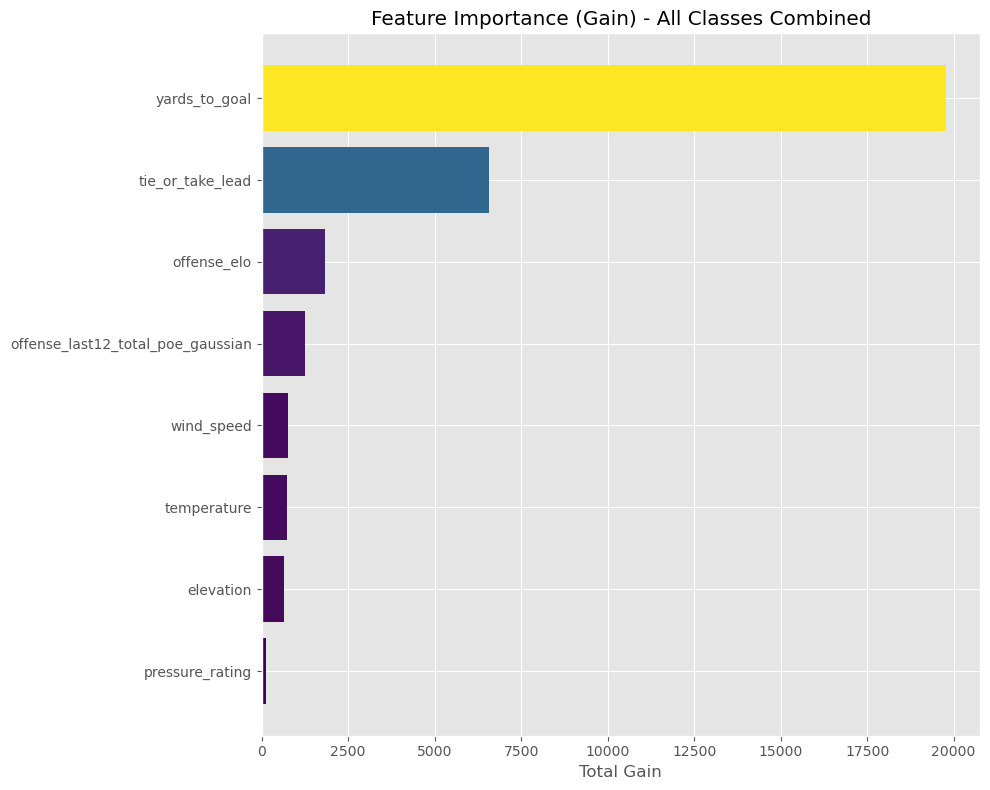

In [113]:
import matplotlib.cm as cm

num_classes = 2
class_names = ['Missed', 'Made']
trees_df = final_model.trees_to_dataframe()

# Aggregate gain across both classes
all_class_trees = trees_df[trees_df['Feature'] != 'Leaf']
total_gain = (
    all_class_trees
    .groupby('Feature')['Gain']
    .sum()
    .sort_values(ascending=False)
)
top_features = total_gain[:20]
norm = plt.Normalize(top_features.min(), top_features.max())
colors = cm.viridis(norm(top_features.values))

plt.figure(figsize=(10, 8))
plt.barh(top_features.index, top_features.values, color=colors)
plt.title("Feature Importance (Gain) - All Classes Combined")
plt.xlabel("Total Gain")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

100%|██████████| 3/3 [00:05<00:00,  1.74s/it]
/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_24317/506683757.py:18: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values,


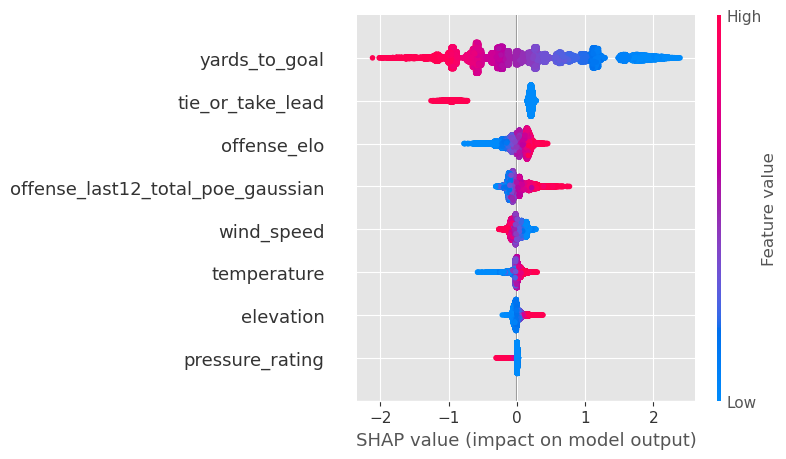

In [114]:
chunk_size = 10000
n_row = 100000

background = train_data[feature_names].iloc[:n_row]
explainer = shap.TreeExplainer(final_model)

num_rows = background.shape[0]

shap_values = []

for i in tqdm(range(0, num_rows, chunk_size)):
    chunk = background.iloc[i:i+chunk_size]
    shap_chunk = explainer(chunk)
    shap_values.append(shap_chunk.values)

shap_values = np.concatenate(shap_values, axis=0)

shap.summary_plot(shap_values, 
                 background,
                 plot_type="dot",  # "dot" (default), "bar", or "violin"
                 max_display=15,
                 show=True)

In [115]:
fg_attempts['proba_make'] = final_model.predict(xgb.DMatrix(fg_attempts[feature_names]))

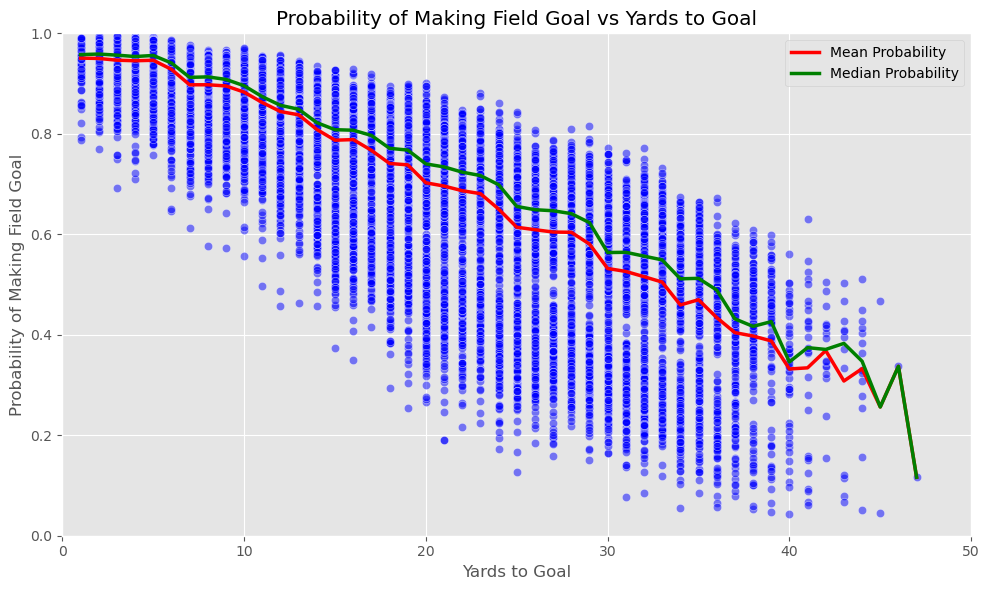

In [122]:
# plot the proba_make against yards_to_goal
plt.figure(figsize=(10, 6))
sns.scatterplot(    
    x='yards_to_goal', 
    y='proba_make', 
    data=fg_attempts, 
    alpha=0.5, 
    color='blue'
)
# plot the mean at each yards_to_goal
mean_proba = (
    fg_attempts
    .groupby('yards_to_goal')['proba_make']
    .mean()
    .reset_index()
)
sns.lineplot(
    x='yards_to_goal', 
    y='proba_make', 
    data=mean_proba, 
    color='red', 
    linewidth=2.5, 
    label='Mean Probability'
)
median_proba = (
    fg_attempts
    .groupby('yards_to_goal')['proba_make']
    .median()
    .reset_index()
)
sns.lineplot(
    x='yards_to_goal', 
    y='proba_make', 
    data=median_proba, 
    color='green', 
    linewidth=2.5, 
    label='Median Probability'
)
plt.title('Probability of Making Field Goal vs Yards to Goal')
plt.xlabel('Yards to Goal')
plt.ylabel('Probability of Making Field Goal')  
plt.xlim(0, 50)
plt.ylim(0, 1)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

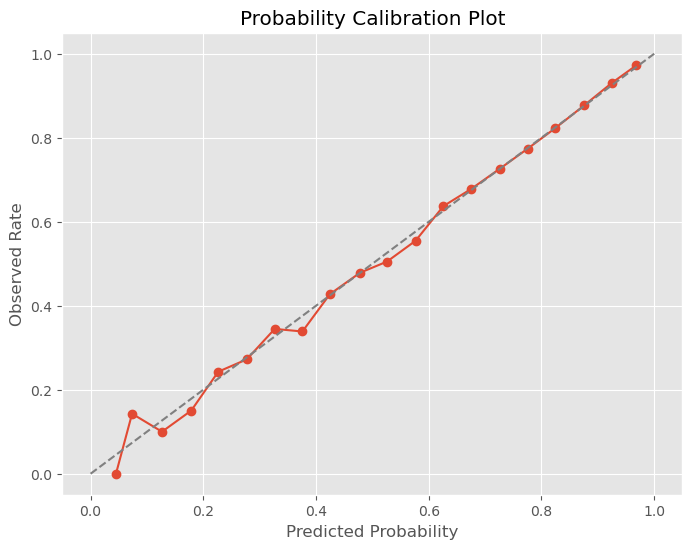

In [116]:
calibration = pd.DataFrame()
def plot_calibration(df, proba_col, actual_col, bins=100, scale=0.2):
    global calibration
    df['proba_bin'] = pd.cut(df[proba_col], bins=np.linspace(0, 1, bins + 1), labels=False, include_lowest=True)
    calibration = df.groupby('proba_bin').agg(
        predicted_proba=(proba_col, 'mean'),
        actual_proba=(actual_col, 'mean'),
        count=(proba_col, 'size')
    ).reset_index()

    plt.figure(figsize=(8, 6))
    plt.plot(calibration['predicted_proba'], calibration['actual_proba'], label='Calibration Curve', marker='o')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
    plt.xlabel('Predicted Probability')
    plt.ylabel('Observed Rate')
    plt.title('Probability Calibration Plot')
    plt.grid(True)
    plt.show()

plot_calibration(fg_attempts, proba_col='proba_make', actual_col='fg_made', bins=20)

In [117]:
model_dir = join('../models/raw', 'field_goal')
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

model_path = os.path.join(model_dir, f"make_proba_xgb.bin")
final_model.save_model(model_path)

print(f"Saved model to the '{model_dir}' folder.")

Saved model to the '../models/raw/field_goal' folder.


/var/folders/cn/x384rbv51ss4zc1t6spzs7_r0000gn/T/ipykernel_24317/1737949603.py:6: UserWarning: [22:27:37] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1748292887431/work/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  final_model.save_model(model_path)


# Model 3: Field Goal blocked Recovery Yardline Model

In [ ]:
#TODO: fg model needs to predict proba for all YTG values 100 to 1